<a href="https://colab.research.google.com/github/tanat1994/Fake-news-Classification/blob/main/Fake_True_News_Classification_with_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='0'></a>
# TABLE OF CONTENTS
- [1. Environment Setup](#1)
- [2. Import Libraries](#2)
- [3. Add Dataframe label & Merge](#3)
- [4. Exploratory Data Analysis(EDA)](#4)
- [5. Dataframe Preprocessing](#5)
    - [5.1 Tokenize function](#5.1)
    - [5.2 Split Train/Test](#5.2)
    - [5.3 Encode/Tokenize dataset](#5.3)
- [6. Modeling](#6)
- [7. Evaluation](#7)
    - [7.1 DistilBERT results](#7.1)
    - [7.2 BertBased results](#7.2)

<a name='1'></a>
## 1. Environment Setup
[Back to TOC](#0)

In [1]:
!pip install -q transformers
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# ! kaggle datasets list
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

100% 41.0M/41.0M [00:02<00:00, 24.6MB/s]
100% 41.0M/41.0M [00:02<00:00, 16.6MB/s]


In [5]:
!unzip fake-and-real-news-dataset.zip

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


<a name='2'></a>
## 2. Import Libraries
[Back to TOC](#0)

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, BertTokenizer, TFBertModel, TFBertForSequenceClassification

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

<a name='3'></a>
## 3. Add Dataframe label & Merge
[Back to TOC](#0)

In [7]:
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

In [8]:
true_df.shape, fake_df.shape

((21417, 4), (23481, 4))

In [9]:
true_df['label'] = 1
fake_df['label'] = 0
full_df = pd.concat([true_df, fake_df], axis=0)

In [10]:
full_df.shape

(44898, 5)

In [11]:
full_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


<a name='4'></a>
## 4. Exploratory Data Analysis(EDA)
[Back to TOC](#0)

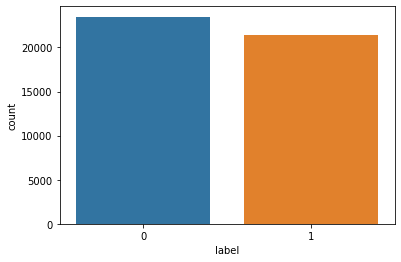

In [12]:
sns.countplot(data=full_df, x='label')

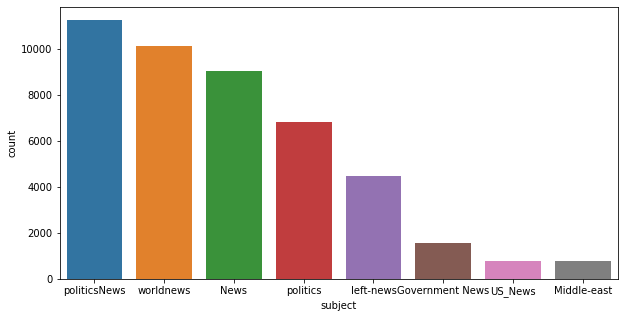

In [13]:
plt.figure(figsize=(10, 5))
order_by_subject = full_df['subject'].value_counts().sort_values(ascending=False).index
sns.countplot(data=full_df, x='subject', order=order_by_subject)

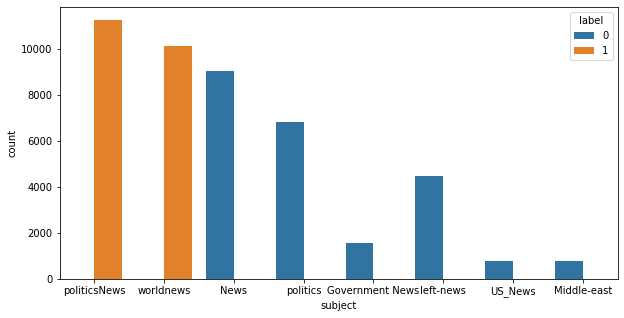

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(data=full_df, x='subject', hue='label')

In [15]:
full_df.groupby(['subject', 'label'], sort=False)['label'].count()

subject          label
politicsNews     1        11272
worldnews        1        10145
News             0         9050
politics         0         6841
Government News  0         1570
left-news        0         4459
US_News          0          783
Middle-east      0          778
Name: label, dtype: int64

<a name='5'></a>
## 5. Dataframe Preprocessing
[Back to TOC](#0)

In [16]:
full_df = full_df.drop(columns=['text', 'subject', 'date'])
full_df.head(2)

,title,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1


In [17]:
full_df['title_len'] = full_df['title'].str.split().str.len()
full_df.sample(3, random_state=42)

,title,label,title_len
799,BREAKING: GOP Chairman Grassley Has Had Enoug...,0,11
6500,Failed GOP Candidates Remembered In Hilarious...,0,9
3590,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,0,14


In [18]:
MAX_LENGTH = 42

In [19]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

<a name='5.1'></a>
### 5.1 Tokenize Function
[Back to TOC](#0)

In [20]:
MAX_LENGTH = 64 #42 # maxlength for new's topic
def tokenize_word(text):
  toks = tokenizer(text, 
                   max_length=MAX_LENGTH, 
                   padding='max_length', 
                   truncation=True, 
                   return_tensors='tf')
  toks = {
      'input_ids': toks['input_ids'][0],
      'attention_mask': toks['attention_mask'][0]
  }
  return toks

In [21]:
def inputs_tokenizer(df):
  input_ids = []
  attention_masks = []
  for title in df['title'].tolist():
    tokens = tokenize_word(title)
    input_ids.append(tokens['input_ids'])
    attention_masks.append(tokens['attention_mask'])
  
  inputs = {
      'input_ids': np.asarray(input_ids, dtype='int32'),
      'attention_mask': np.asarray(attention_masks, dtype='int32')
  }
  return inputs

<a name='5.2'></a>
### 5.2 Split Train/Test
`Training 80%`

`Validation 20%`

[Back to TOC](#0)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns=['label']), full_df['label'], test_size=0.2, stratify=full_df['label'], random_state=42)

In [23]:
X_train.shape, X_test.shape

((35918, 2), (8980, 2))

<a name='5.3'></a>
### 5.3 Encode/Tokenize dataset

Tokenize each sentence and add special token [CLS], [SEP]

[Back to TOC](#0)

In [24]:
X_train_inputs = inputs_tokenizer(X_train)
X_test_inputs = inputs_tokenizer(X_test)

<a name='6'></a>
## 6. Modeling
[Back to TOC](#0)

**Model Summary**
- Pre-trained Model => `distilbert-base-uncased | bert-base-uncased`
  - trainable = `True | False` 
- Dropout => `0.1`
- Epochs => `3 (4 cause overfitting)`
    - learning rates => `[3e-4, 1e-4, 5e-5, 3e-5]` # value from BERT paper
    - batch sizes => `8, 16, 32, 64, 128`
    - ref. [https://github.com/google-research/bert](https://github.com/google-research/bert)

In [42]:
def create_model(bert_model):
  input_ids = Input(shape=(MAX_LENGTH,), dtype='int32', name='input_ids')
  attention_masks = Input(shape=(MAX_LENGTH,), dtype='int32', name='attention_masks')

  # TFDistilbertModel
  embedding = bert_model(input_ids, attention_masks)[0] 
  output = Dense(32, activation='relu')(embedding[:, 0, :])
  output = tf.keras.layers.Dropout(rate=0.1)(output)
  output = Dense(1, activation='sigmoid')(output)
  
  # TFBertModel
  # embedding = bert_model(input_ids, attention_masks)[1] #pooled output
  # output = Dense(32, activation='relu')(embedding)
  # output = tf.keras.layers.Dropout(rate=0.1)(output)
  # output = Dense(1, activation='sigmoid')(output)

  model = Model(inputs=[input_ids, attention_masks], outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
  return model

In [43]:
base = TFDistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=2)
# base = TFBertModel.from_pretrained('bert-base-uncased', num_labels=2)
for layer in base.layers:
  layer.trainable = True
  # layer.trainable = False
base.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [44]:
model = create_model(base)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 64)]         0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_masks[0][0]']        
                                one, 64, 768),                                                    
                                 hidden_states=None                                         

In [45]:
history = model.fit([X_train_inputs['input_ids'], X_train_inputs['attention_mask']], 
          y_train, 
          batch_size=64, 
          epochs=3,
          validation_data=([X_test_inputs['input_ids'], X_test_inputs['attention_mask']], y_test))

Epoch 1/3
562/562 [==============================] - 237s 409ms/step - loss: 0.0743 - accuracy: 0.9723 - val_loss: 0.0337 - val_accuracy: 0.9873
Epoch 2/3
562/562 [==============================] - 228s 406ms/step - loss: 0.0249 - accuracy: 0.9921 - val_loss: 0.0375 - val_accuracy: 0.9867
Epoch 3/3
562/562 [==============================] - 228s 407ms/step - loss: 0.0120 - accuracy: 0.9958 - val_loss: 0.0488 - val_accuracy: 0.9875


<a name='7'></a>
## 7. Evaluation
[Back to TOC](#0)

In [107]:
y_pred = model.predict([X_test_inputs['input_ids'], X_test_inputs['attention_mask']])

281/281 [==============================] - 19s 67ms/step


In [108]:
y_pred = np.round(y_pred).astype(int).ravel()

<a name='7.1'></a>
###  7.1 DistilBERT results
[Back to TOC](#0)

#### Trainable = TRUE

- Elapsed: `238s`

- Results: `accuracy: 0.9594 - val_accuracy: 0.9835`

#### Trainable = FALSE
- Elapsed: `99s`

- Results: `accuracy: 0.8286 - val_accuracy: 0.8861`

<a name='7.2'></a>
### 7.2 BertBased results
[Back to TOC](#0)

#### Trainable = TRUE

- Elapsed: `471s`

- Results: `accuracy: 0.9871 - val_accuracy: 0.9839`

#### Trainable = FALSE

- Elapsed: `199s`

- Results: `accuracy: 0.7195 - val_accuracy: 0.7667`

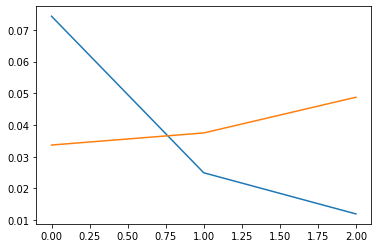

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [109]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [117]:
acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy score = {acc_score:.2f}%')

Accuracy score = 0.99%


In [111]:
f1_score = f1_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)

In [121]:
scores = [['accuracy', acc_score], ['f1', f1_score], ['precision', precision_score], ['recall', recall_score]]
metrics_df = pd.DataFrame(scores, columns=['metrics', 'score'])
metrics_df

,metrics,score
0,accuracy,0.987528
1,f1,0.986916
2,precision,0.987839
3,recall,0.985994


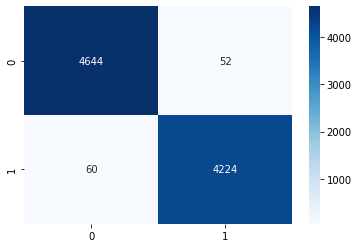

In [52]:
cf_matrix = confusion_matrix(y_test, np.round(y_pred).astype(int).ravel().reshape(-1, 1))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')